# Confusion Matrices - Part 2

---

This post takes off where the [last one](https://scottminer.netlify.app/post/confusion-matrix/) left off and talks about building confusion matrices for multi-class classification problems. We load the Iris dataset, split it into training and test sets, build a _K_-Nearest Neighbors (_k_-NN) classifier that attempts to predict the class of Iris plant (setosa, versicolor, or virginica), and craft a confusion matrix using these predictions. We then describe some additional metrics, including the `macro` and `micro` precision, and discuss `sklearn`'s `classification_report`, discussing the $F_1$ metric and delving slightly deeper into the $F_{0.5}$ and $F_2$ metrics. In the end, we discuss the `classification_report` for the confusion matrix we built on the Iris dataset. 

Let's import the needed libraries and set the `matplotlib` and `seaborn` settings.

# Imports

---


In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, recall_score, classification_report, f1_score, fbeta_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
import warnings
import re
warnings.simplefilter(action='ignore', category=[FutureWarning])

## Matplotlib & Seaborn Settings

---


In [2]:
mpl.rcParams.update({'font.size': 26})
mpl.rc('figure', figsize=(8, 8))
sns.set(font_scale=2.0)
sns.color_palette("deep")
%matplotlib inline

# Iris Dataset

---

Let's fit a *k*-NN classifier on the Iris training data and generate predictions on the test features to build a confusion matrix.

Size of full dataset: 150
Size of test dataset: 50

accuracy: 0.94

confusion matrix:
[[18  0  0]
 [ 0 16  1]
 [ 0  2 13]]


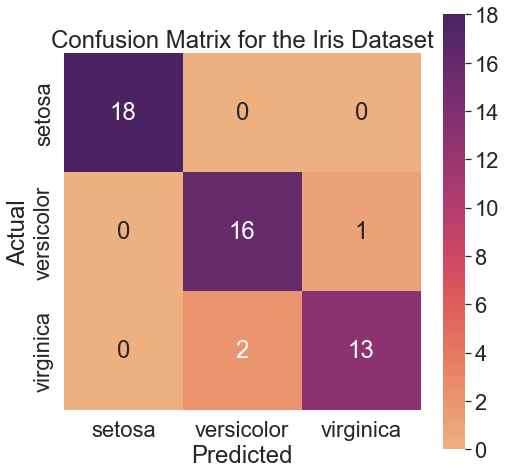

In [3]:
# Load the iris dataset
iris = datasets.load_iris()

# How many elements are in the data set?
print(f'Size of full dataset: {len(iris.data)}')

# Split the data into training and testing sets
tts_iris = train_test_split(iris.data, iris.target,
                            test_size=.33, random_state=21)

# Output the result of the train_test_split to a tuple
(iris_train_ftrs, iris_test_ftrs,
 iris_train_tgt, iris_test_tgt) = tts_iris

# The test set should contain 50 elements, since we set the size to a third
print(f'Size of test dataset: {len(iris_test_ftrs)}')
print()
tgt_preds = (KNeighborsClassifier()
             .fit(iris_train_ftrs, iris_train_tgt)
             .predict(iris_test_ftrs))

print("accuracy:", accuracy_score(iris_test_tgt, tgt_preds))
print()
# Print classifier
cm = confusion_matrix(iris_test_tgt, tgt_preds)
print("confusion matrix:", cm, sep="\n")

# Draw confusion matrix using seaborn
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax = sns.heatmap(cm, annot=True, square=True,
                 xticklabels=iris.target_names,
                 yticklabels=iris.target_names,
                 fmt='g', cmap='flare', annot_kws={"size": 24})
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix for the Iris Dataset')
plt.show()

The _k_-NN classifier identified all setosa examples correctly. The classifier misclassified one versicolor as a setosa. Also, the classifier misclassified two virginicas as versicolors. The remaining 16 versicolors and 13 virginicas were classified correctly.

# Averaging Multiple Classes

---

When dealing with the Iris dataset, we are no longer dealing with two classes like we were with the MNIST dataset, causing our dichotomous formulas for `precision` and `recall` to break down. However, we can calculate something similar to `precision`, taking a one-versus-rest approach and comparing each class to all others. For the setosa class, we predict $\frac{18}{18} = 1$, versicolor, $\frac{16}{18}$, and virginica, $\frac{13}{14}$. Let's take the mean.

In [4]:
np.mean([1, 16/18, 13/14])

0.9391534391534391

We calculate this same mean in `sklearn` by setting the `average` parameter of the `precision_score` function to `macro`.

## Macro Precision

---

To calculate the macro precision, we take the diagonal entry for each column in the confusion matrix and divide it by the total predictions per column. We then sum these values and divide the result by the total number of columns.

In [5]:
macro_prec = precision_score(iris_test_tgt,
                             tgt_preds,
                             average='macro')
print(f'Macro Precision: {macro_prec}')

cm = confusion_matrix(iris_test_tgt, tgt_preds)
n_labels = len(iris.target_names)
print(                                 # correct     # column calc         # total cols
    f"Should Equal 'Macro Precision': {(np.diag(cm) / cm.sum(axis=0)).sum() / n_labels}")

Macro Precision: 0.9391534391534391
Should Equal 'Macro Precision': 0.9391534391534391


## Micro Precision

---

The micro precision is named somewhat counterintuitively, providing a broader look at the results than the macro average. To calculate the micro precision, we divide all the correct predictions by the total number of predictions. We can perform this calculation manually by summing the values on the diagonal of the confusion matrix and dividing by the sum of all values in the confusion matrix.

In [6]:
print("Micro Precision:", precision_score(iris_test_tgt, tgt_preds, average='micro'))

cm = confusion_matrix(iris_test_tgt, tgt_preds)
print("Should Equal 'Micro Precision':",
      np.diag(cm).sum() / cm.sum())

Micro Precision: 0.94
Should Equal 'Micro Precision': 0.94


## Classification Report

---

The `classification_report` builds a text report showing some of these metrics. Let's take a look at what it returns.

In [7]:
# initial search param
init_index = [i for i, item in enumerate(
    classification_report.__doc__.splitlines()) if re.search(r'Returns', item)]

# find dash index from init_index
dash_index = [i for i, item in enumerate(classification_report.__doc__.splitlines()[
                                         init_index[0] + 2:]) if re.search(r'^\s+----+', item)]

# add to the dash index to make it correct
dash_index[0] += init_index[0]

# print final __doc__ string
print('\n'.join(classification_report.__doc__.splitlines()
      [init_index[0]:dash_index[0]]))

    Returns
    -------
    report : str or dict
        Text summary of the precision, recall, F1 score for each class.
        Dictionary returned if output_dict is True. Dictionary has the
        following structure::

            {'label 1': {'precision':0.5,
                         'recall':1.0,
                         'f1-score':0.67,
                         'support':1},
             'label 2': { ... },
              ...
            }

        The reported averages include macro average (averaging the unweighted
        mean per label), weighted average (averaging the support-weighted mean
        per label), and sample average (only for multilabel classification).
        Micro average (averaging the total true positives, false negatives and
        false positives) is only shown for multi-label or multi-class
        with a subset of classes, because it corresponds to accuracy
        otherwise and would be the same for all metrics.
        See also :func:`precision_recall

According to the docs, the `classification_report` returns each class's `precision`, `recall`, and `f1-score`. We have yet to talk about the $F_1$ score, but we will shortly. The `classification_report` also returns the `macro` average, which is the unweighted mean per label--as described above in the section on `macro` precision--and the weighted average, which averages the support-weighted mean per category.

### Support

---

The support of a classification rule, such as "if x is a big house in a good location, then its value is high," is the count of the examples where the rule applies. In other words, if 100 of 1000 houses are big and in a good location, then the support is 10%. The `classification_report` is concerned with the "support in reality," equivalent to the sum of each row in the confusion matrix.

Before looking at some simple `classification_report` examples, let's look at the $F_1$ score.

# $F_1$ Score

---



The $F_1$ score is a standard measure to rate a classifier's success. It is also known as the balanced F-score or F-measure. The $F_1$ score is the harmonic mean of the precision and recall, reaching its best value at 1 and worst score at 0. We compute a harmonic mean by finding the arithmetic mean of the reciprocals of the data and then taking the reciprocal of that. The formula is below:

$$ H = \frac{n}{\frac{1}{x_1} + \frac{1}{x_2} + \frac{1}{x_3} + \ldots + \frac{1}{x_n}} $$

$H$ is the harmonic mean, $n$ is the number of data points, and $x_n$ is the nth value in the dataset.

Applying this formula to the precision and recall, we get the following:

$$ F_1 = \frac{2}{\frac{1}{\text{precision}} + \frac{1}{\text{recall}}} = \frac{2 \times \text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}} = \frac{\text{tp}}{\text{tp} + \frac{1}{2}(\text{fp} + \text{fn})} $$

The precision and recall measure two types of errors we can make regarding the positive class. Maximizing the precision minimizes false positives, whereas maximizing the recall minimizes false negatives. The $F_1$ score represents an equal tradeoff between precision and recall, meaning we want to be accurate both in the value of our predictions and concerning reality. 

Let's take a look at a few worst-case scenarios.

## Worst-Case Scenarios

---

If our classifier perfectly mispredicts all instances, we have zero `precision` and zero `recall`, resulting in a zero $F_1$ score. All negative predictions result in the same values for all three metrics.

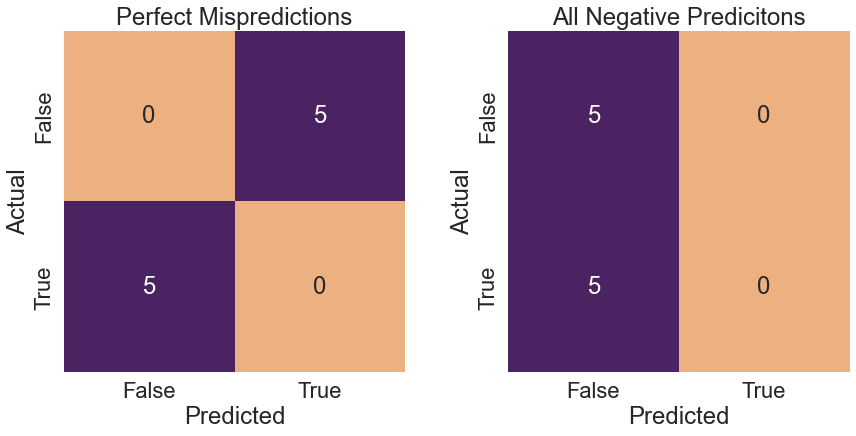

1. Perfect Mispredictions
-----------------------------
y_true: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
y_pred: [1, 1, 1, 1, 1, 0, 0, 0, 0, 0]

True Negatives: 0
False Positives: 5
True Positives: 0
False Negatives: 5

Recall: 0.000
Precision: 0.000
F1-Score: 0.000

2. All Negative Predicitons
-----------------------------
y_true: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
y_pred: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

True Negatives: 5
False Positives: 0
True Positives: 0
False Negatives: 5

Recall: 0.000
Precision: 0.000
F1-Score: 0.000



In [8]:
# Worst Case
titles = ['Perfect Mispredictions', 'All Negative Predicitons']
y_true = [[0, 0, 0, 0, 0, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]]
y_pred = [[1, 1, 1, 1, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
fig, axes = plt.subplots(1, 2, figsize=(12, 8))

for i, (ax, y_t, y_p, title) in enumerate(zip(axes.flat, y_true, y_pred, titles)):
    cm = confusion_matrix(y_t, y_p)
    ax = sns.heatmap(cm, annot=True, square=True,
                     xticklabels=['False', 'True'],
                     yticklabels=['False', 'True'],
                     fmt='g', cmap='flare', ax=ax, cbar=False, annot_kws={"size": 24})
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title(title)

plt.tight_layout()
plt.subplots_adjust(wspace=0.3)
plt.show()
for i, (y_t, y_p, title) in enumerate(zip(y_true, y_pred, titles)):
    print(f'{i + 1}. {title}')
    print('-----------------------------')
    print(f'y_true: {y_t}')
    print(f'y_pred: {y_p}')
    print()
    (tn, fp, fn, tp) = confusion_matrix(y_t, y_p).ravel()
    print(f'True Negatives: {tn}')
    print(f'False Positives: {fp}')
    print(f'True Positives: {tp}')
    print(f'False Negatives: {fn}')
    print()
    print(
        f'Recall: {recall_score(y_t, y_p):.3f}')
    print(f'Precision: {precision_score(y_t, y_p, zero_division=0):.3f}')
    print(
        f'F1-Score: {f1_score(y_t, y_p):.3f}'
    )
    print()


Given that neither classifier output any positive predictions, the `recall`, `precision`, and `f1-score` are all 0.

## Best Case

---

Conversely, a perfect classifier outputs perfect `recall`, `precision`, and `f1-scores`.

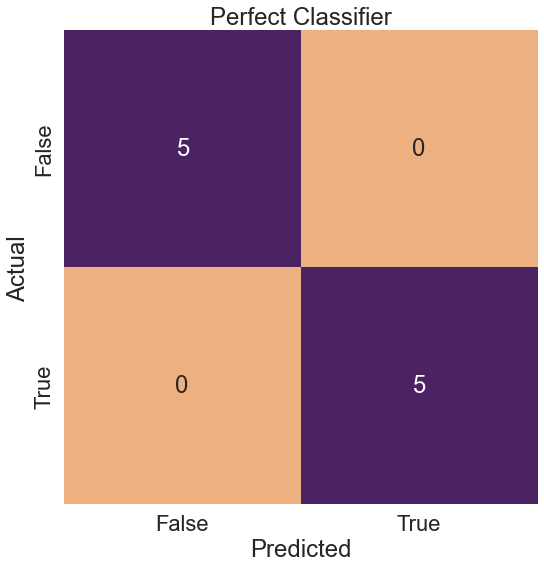

1. Perfect Classifier
-----------------------------
y_true: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
y_pred: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]

True Negatives: 5
False Positives: 0
True Positives: 5
False Negatives: 0

Recall: 1.000
Precision: 1.000
F1-Score: 1.000



In [9]:
# Best Case
titles = ['Perfect Classifier']
y_true = [[0, 0, 0, 0, 0, 1, 1, 1, 1, 1]]
y_pred = [[0, 0, 0, 0, 0, 1, 1, 1, 1, 1]]
fig, axes = plt.subplots(1, 1, figsize=(8, 8), squeeze=0)

for i, (ax, y_t, y_p, title) in enumerate(zip(axes.flat, y_true, y_pred, titles)):
    cm = confusion_matrix(y_t, y_p)
    ax = sns.heatmap(cm, annot=True, square=True,
                     xticklabels=['False', 'True'],
                     yticklabels=['False', 'True'],
                     fmt='g', cmap='flare', ax=ax, cbar=False, annot_kws={"size": 24})
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title(title)

plt.tight_layout()
plt.subplots_adjust(wspace=0.3)
plt.show()
for i, (y_t, y_p, title) in enumerate(zip(y_true, y_pred, titles)):
    print(f'{i + 1}. {title}')
    print('-----------------------------')
    print(f'y_true: {y_t}')
    print(f'y_pred: {y_p}')
    print()
    (tn, fp, fn, tp) = confusion_matrix(y_t, y_p).ravel()
    print(f'True Negatives: {tn}')
    print(f'False Positives: {fp}')
    print(f'True Positives: {tp}')
    print(f'False Negatives: {fn}')
    print()
    print(
        f'Recall: {recall_score(y_t, y_p):.3f}')
    print(f'Precision: {precision_score(y_t, y_p, zero_division=0):.3f}')
    print(
        f'F1-Score: {f1_score(y_t, y_p):.3f}'
    )
    print()


Before discussing a classifier with perfect recall and 50% precision, let's discuss the $F_{\beta}$ measure.

# $F_{\beta}$ Score

---


The $F_1$ score equally balances precision and recall. However, in some problems, we may be more interested in minimizing false negatives, such as when attempting to identify a rare disease. In other circumstances, we may be more interested in reducing false positives, such as when trying to classify web pages according to search engine requests. 

To solve problems of this nature, we can use $F_{\beta}$, an abstraction of $F_1$ that allows us to control the balance of precision and recall using a coefficient, $\beta$.

$$ F_\beta = \frac{((1 + \beta^2) \times \text{Precision} \times \text{Recall})}{\beta^2 \times \text{Precision} + \text{Recall}} $$

Three common values for $\beta$ are as follows:

* $F_{0.5}$: places more weight on precision.
* $F_1$: places equal weight on precision and recall.
* $F_2$: places more weight on recall.

Let's take a closer look at each.

## $F_{0.5}$ Measure

---

$F_{0.5}$ raises the importance of precision and lowers the significance of recall, focusing more on minimizing false positives.

$$ F_{0.5} = \frac{((1 + 0.5^2) \times \text{Precision} \times \text{Recall})}{(0.5^2 \times \text{Precision} + \text{Recall})} = \frac{(1.25 \times \text{Precision} + \text{Recall})}{(0.25 \times \text{Precision} + \text{Recall})}$$

## $F_1$ Measure

---

The $F_1$ measure discussed above is an example of $F_{\beta}$ with a $\beta$ value of 1.

$$ F_{1} = \frac{((1 + 1^2) \times \text{Precision} \times \text{Recall})}{(1 ^ 2 \times \text{Precision} + \text{Recall})} = \frac{(2 \times \text{Precision} + \text{Recall})}{(\text{Precision} + \text{Recall})}$$

## $F_2$ Measure

---

The $F_2$ measure increases the significance of recall and lowers the importance of precision. The $F_{2}$ measure focuses more on minimizing false negatives.

$$ F_2 = \frac{((1 + 2^2) \times \text{Precision} \times \text{Recall})}{(2 ^ 2 \times \text{Precision} + \text{Recall})} = \frac{(5 \times \text{Precision} + \text{Recall})}{(4 \times \text{Precision} + \text{Recall})}$$


Because precision and recall require true positives, having one without the other is impossible.

Let's consider a case where a classifier makes predictions resulting in perfect recall and 50% precision.

We'll create a classifier that predicts all positives.

# Perfect Recall, 50% Precision

---


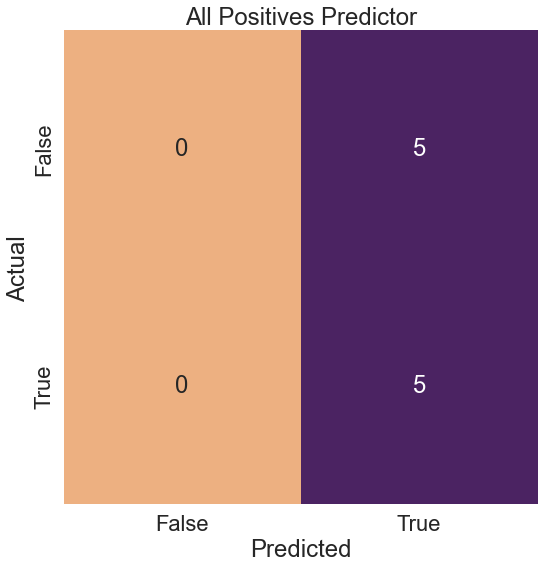

1. All Positives Predictor
-----------------------------
y_true: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
y_pred: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

True Negatives: 0
False Positives: 5
True Positives: 5
False Negatives: 0

Recall: 1.000
Precision: 0.500

F0.5-Score: 0.556
F1-Score: 0.667
F2-Score: 0.833



In [10]:
#50% Precision, Perfect Recall
titles = ['All Positives Predictor']
y_true = [[0, 0, 0, 0, 0, 1, 1, 1, 1, 1]]
y_pred = [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]

fig, axes = plt.subplots(1, 1, figsize=(8, 8), squeeze=0)

for i, (ax, y_t, y_p, title) in enumerate(zip(axes.flat, y_true, y_pred, titles)):
    cm = confusion_matrix(y_t, y_p)
    ax = sns.heatmap(cm, annot=True, square=True,
                     xticklabels=['False', 'True'],
                     yticklabels=['False', 'True'],
                     fmt='g', cmap='flare', ax=ax, cbar=False, annot_kws={"size": 24})
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title(title)

plt.tight_layout()
plt.show()

for i, (y_t, y_p, title) in enumerate(zip(y_true, y_pred, titles)):
    print(f'{i + 1}. {title}')
    print('-----------------------------')
    print(f'y_true: {y_t}')
    print(f'y_pred: {y_p}')
    print()
    (tn, fp, fn, tp) = confusion_matrix(y_t, y_p).ravel()
    print(f'True Negatives: {tn}')
    print(f'False Positives: {fp}')
    print(f'True Positives: {tp}')
    print(f'False Negatives: {fn}')
    print()
    print(
        f'Recall: {recall_score(y_t, y_p):.3f}')
    print(f'Precision: {precision_score(y_t, y_p, zero_division=0):.3f}')
    print()
    print(
        f'F0.5-Score: {fbeta_score(y_t, y_p, beta=0.5):.3f}'
    )
    print(f'F1-Score: {fbeta_score(y_t, y_p, beta=1):.3f}')
    print(
        f'F2-Score: {fbeta_score(y_t, y_p, beta=2):.3f}'
    )
    print()

There are no false negatives (incorrect misses), so the `recall` is 1.0.
Because there are false positives, the `precision` (0.50) takes a hit, and ultimately the $F_1$ score (0.667).
Because the $F_{0.5}$ score (0.556) places more emphasis on `precision`, its value is lower than that of the $F_1$ score (0.667).
The $F_{2}$ score is the highest of all three `f-scores` (0.833) since it emphasizes `recall` over `precision`.

Let's look at some simple examples of the `classification_report` function.

# Classification Report - Simple Example #1

---


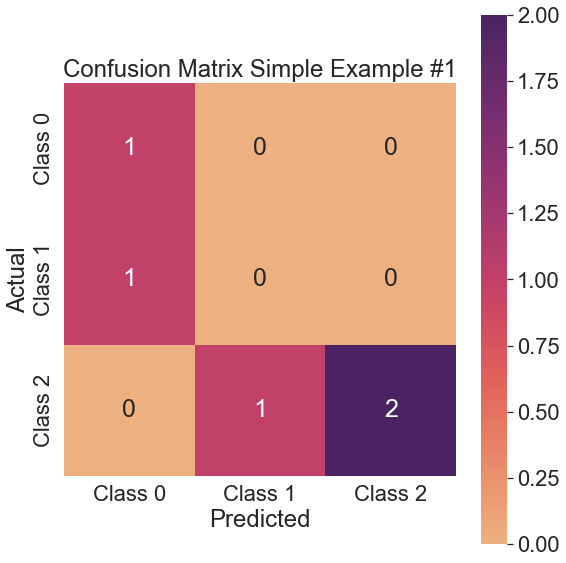

Y True: [0, 1, 2, 2, 2]
Y Pred: [0, 0, 2, 2, 1]

              precision    recall  f1-score   support

     class 0       0.50      1.00      0.67         1
     class 1       0.00      0.00      0.00         1
     class 2       1.00      0.67      0.80         3

    accuracy                           0.60         5
   macro avg       0.50      0.56      0.49         5
weighted avg       0.70      0.60      0.61         5



In [11]:
# Classification Report Simple Example 1
y_true = [0, 1, 2, 2, 2]
y_pred = [0, 0, 2, 2, 1]
target_names = ['class 0', 'class 1', 'class 2']
cm = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
cm = confusion_matrix(y_true, y_pred)
ax = sns.heatmap(cm, annot=True, square=True,
                 xticklabels=['Class 0', 'Class 1', 'Class 2'],
                 yticklabels=['Class 0', 'Class 1', 'Class 2'],
                 fmt='g', cmap='flare', annot_kws={"size": 25})
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix Simple Example #1')
plt.tight_layout()
plt.show()
print(f'Y True: {y_true}')
print(f'Y Pred: {y_pred}')
print()
print(classification_report(y_true, y_pred, target_names=target_names))

Regarding `Class 0`, the classifier predicted one instance correctly and incorrectly identified a real `1` as a `0`, resulting in a false positive. Consequently, the `precision` takes a hit (0.5), though the `recall` remains high at 1.0. The $F_1$ score is 0.67.

The classifier did not predict any instances of `Class 1` correctly, resulting in all metrics having values of 0.0.

The classifier did the best on `Class 2`, predicting two instances correctly and one as `Class 1`. As a result, there are no false positives, so the `precision` remains high at 1.0. There is one false negative, so the `recall` is reduced to 0.67, and the $F_1$ measure is 0.80.

# Classification Report - Simple Example #2

---

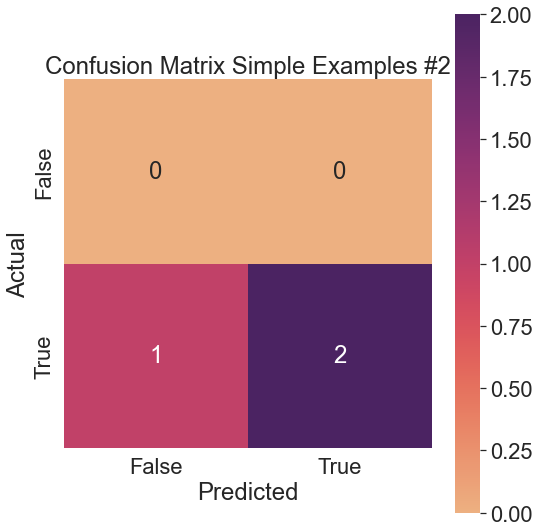

Y True: [1, 1, 1]
Y Pred: [0, 1, 1]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.67      0.80         3

    accuracy                           0.67         3
   macro avg       0.50      0.33      0.40         3
weighted avg       1.00      0.67      0.80         3



In [12]:
# Classification Report Simple Example #2
y_true = [1, 1, 1]
y_pred = [0, 1, 1]
cm = confusion_matrix(y_true, y_pred)
sns.set(font_scale=2.0)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
cm = confusion_matrix(y_true, y_pred)
ax = sns.heatmap(cm, annot=True, square=True,
                 xticklabels=['False', 'True'],
                 yticklabels=['False', 'True'],
                 fmt='g', cmap='flare')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix Simple Examples #2')
plt.tight_layout()
plt.show()
print(f'Y True: {y_true}')
print(f'Y Pred: {y_pred}')
print()
print(classification_report(y_true, y_pred, zero_division=0))

There are no instances of `Class 0`, resulting in `precision`, `recall`, and `f1-scores` of 0.

The classifier achieves perfect `precision` (1.0) on the positive class, never predicting any false positives. The `recall` (0.67) takes a hit because there is one false negative.

The `macro avg` considers both classes in its `precision`, `recall`, and `f1-score` calculations. 

In contrast, the `weighted avg` only considers the positive class since the support weights the calculation according to reality.

This is why class `1` and the `weighted avg` rows contain equal values for `precision` (1.00), `recall` (0.67), and the `f1-score` (0.80).

Let's apply the `classification_report` function to the _k_-NN classifier we built on the Iris dataset.

# Classification Report - Iris Dataset

---

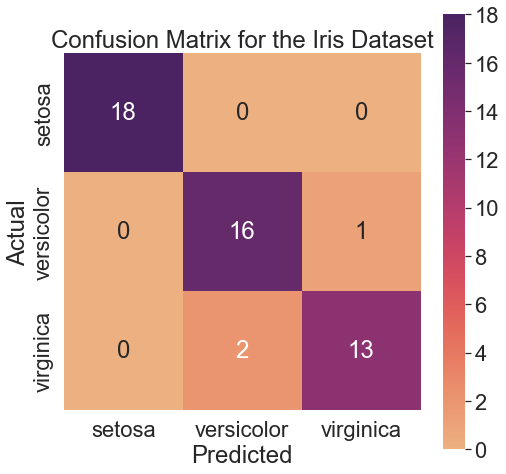

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        18
  versicolor       0.89      0.94      0.91        17
   virginica       0.93      0.87      0.90        15

    accuracy                           0.94        50
   macro avg       0.94      0.94      0.94        50
weighted avg       0.94      0.94      0.94        50



In [13]:
# Classification report for Iris dataset
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
cm = confusion_matrix(iris_test_tgt, tgt_preds)
ax = sns.heatmap(cm, annot=True, square=True,
                 xticklabels=['setosa', 'versicolor', 'virginica'],
                 yticklabels=['setosa', 'versicolor', 'virginica'],
                 fmt='g', cmap='flare')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix for the Iris Dataset')
plt.show()
print(classification_report(iris_test_tgt, tgt_preds, target_names=['setosa', 'versicolor', 'virginica']))

We see the setosa class is the easiest to predict, and the _k_-NN classifier predicted all examples in the test dataset successfully. The `precision`, `recall`, and `f1-score` for this row are 1.00.

The classifier is slightly less precise on the versicolor class (0.89) since it misclassifies two virginicas as versicolors, as compared to the virginica class (0.93), where it only misclassifies one versicolor as a virginica.

The `recall` for the versicolor class (0.94) is higher than that for the virginica class (0.87) because the classifier only misclassified one versicolor, whereas it misclassified two virginicas.

The resulting `f1-scores` for versicolor and virginica are 0.91 and 0.90, respectively. Versicolor is slightly above virginica, indicating that the classifier performed slightly better on that class.

The `macro avg` and `weighted avg` for the `precision`, `recall`, and `f1-score` are equal (0.94), indicating the _k_-NN classifier performs relatively well, and the classes are distributed relatively equally amongst the target variable.

In the next post, we will discuss ROC curves, otherwise known as _receiver operating characteristic_ curves.